In [1]:
import numpy as np
import tensorflow as tf
from tensorflow import feature_column
from tensorflow import keras
from sklearn.preprocessing import StandardScaler
import pandas as pd
import seaborn as sns
from pylab import rcParams
import matplotlib.pyplot as plt
from matplotlib import rc
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix

import warnings
warnings.filterwarnings('ignore')

2023-10-25 17:13:28.796530: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-10-25 17:13:32.142432: E tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:9342] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2023-10-25 17:13:32.142490: E tensorflow/compiler/xla/stream_executor/cuda/cuda_fft.cc:609] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2023-10-25 17:13:32.145305: E tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:1518] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2023-10-25 17:13:33.713091: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-10-25 17:13:33.715050: I tensorflow/core/platform/cpu_feature_guard.cc:182] This Tens

In [2]:
df = pd.read_csv('datasets/numerical_data.csv')

In [3]:
for column in df.columns:
    df[column] = df[column].astype(int)

In [4]:
num_var = ['BMI', 'PhysicalHealth', 'MentalHealth', 'SleepTime']
cat_var = ['Smoking', 'AgeCategory', 'Race', 'Diabetic', 'GenHealth', 'Asthma']
bin_var = ['AlcoholDrinking', 'Stroke', 'DiffWalking', 'Sex', 'KidneyDisease', 'SkinCancer', 'PhysicalActivity']

In [5]:
target = df.pop('HeartDisease')
X_train, X_test, y_train, y_test = train_test_split(df, target, test_size=0.2, random_state=42)

In [6]:
# Normalize numerical features
scaler = StandardScaler()
X_train[num_var] = scaler.fit_transform(X_train[num_var])
X_test[num_var] = scaler.transform(X_test[num_var])

In [7]:
# Define feature columns
feature_columns = []

# Numeric feature columns
for feature_name in num_var:
    feature_columns.append(tf.feature_column.numeric_column(feature_name, dtype=tf.float32))

# Categorical feature columns (use one-hot encoding)
for feature_name in cat_var:
    vocabulary_list = df[feature_name].unique()
    cat_column = tf.feature_column.categorical_column_with_vocabulary_list(feature_name, vocabulary_list)
    one_hot_column = tf.feature_column.indicator_column(cat_column)
    feature_columns.append(one_hot_column)

# Binary feature columns (use one-hot encoding)
for feature_name in bin_var:
    vocabulary_list = df[feature_name].unique()
    bin_column = tf.feature_column.categorical_column_with_vocabulary_list(feature_name, vocabulary_list)
    one_hot_column = tf.feature_column.indicator_column(bin_column)
    feature_columns.append(one_hot_column)

Instructions for updating:
Use Keras preprocessing layers instead, either directly or via the `tf.keras.utils.FeatureSpace` utility. Each of `tf.feature_column.*` has a functional equivalent in `tf.keras.layers` for feature preprocessing when training a Keras model.
Instructions for updating:
Use Keras preprocessing layers instead, either directly or via the `tf.keras.utils.FeatureSpace` utility. Each of `tf.feature_column.*` has a functional equivalent in `tf.keras.layers` for feature preprocessing when training a Keras model.
Instructions for updating:
Use Keras preprocessing layers instead, either directly or via the `tf.keras.utils.FeatureSpace` utility. Each of `tf.feature_column.*` has a functional equivalent in `tf.keras.layers` for feature preprocessing when training a Keras model.


In [8]:
# Build and compile the model
model = tf.keras.Sequential([
    tf.keras.layers.DenseFeatures(feature_columns),
    tf.keras.layers.Dense(units=128, activation='relu'),
    tf.keras.layers.Dropout(rate=0.2),
    tf.keras.layers.Dense(units=128, activation='relu'),
    tf.keras.layers.Dense(units=1, activation='sigmoid')
])

In [9]:
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

In [10]:
# Convert data to TensorFlow datasets
train_ds = tf.data.Dataset.from_tensor_slices((dict(X_train), y_train)).batch(32)
eval_ds = tf.data.Dataset.from_tensor_slices((dict(X_test), y_test)).batch(32)

In [11]:
# Implement early stopping
early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=10,  # Number of epochs with no improvement after which training will be stopped.
    restore_best_weights=True  # Restore model weights from the epoch with the best value of the monitored quantity.
)

In [12]:
# Train the model
history = model.fit(train_ds, validation_data=eval_ds, epochs=100, callbacks=[early_stopping])

Epoch 1/100
9496/9496 [==============================] - 19s 2ms/step - loss: 0.1837 - accuracy: 0.9390 - val_loss: 0.1794 - val_accuracy: 0.9387
Epoch 2/100
9496/9496 [==============================] - 18s 2ms/step - loss: 0.1791 - accuracy: 0.9396 - val_loss: 0.1778 - val_accuracy: 0.9393
Epoch 3/100
9496/9496 [==============================] - 17s 2ms/step - loss: 0.1776 - accuracy: 0.9398 - val_loss: 0.1767 - val_accuracy: 0.9395
Epoch 4/100
9496/9496 [==============================] - 17s 2ms/step - loss: 0.1765 - accuracy: 0.9401 - val_loss: 0.1761 - val_accuracy: 0.9394
Epoch 5/100
9496/9496 [==============================] - 18s 2ms/step - loss: 0.1756 - accuracy: 0.9403 - val_loss: 0.1758 - val_accuracy: 0.9397
Epoch 6/100
9496/9496 [==============================] - 18s 2ms/step - loss: 0.1745 - accuracy: 0.9407 - val_loss: 0.1748 - val_accuracy: 0.9399
Epoch 7/100
9496/9496 [==============================] - 18s 2ms/step - loss: 0.1738 - accuracy: 0.9410 - val_loss: 0.1747 -

In [13]:
# Evaluate the model
predictions = model.predict(eval_ds)
bin_predictions = [1 if p > 0.5 else 0 for p in predictions]

2374/2374 [==============================] - 3s 1ms/step


In [14]:
print(classification_report(y_test, bin_predictions))

              precision    recall  f1-score   support

           0       0.94      1.00      0.97     71267
           1       0.73      0.07      0.13      4694

    accuracy                           0.94     75961
   macro avg       0.84      0.54      0.55     75961
weighted avg       0.93      0.94      0.92     75961



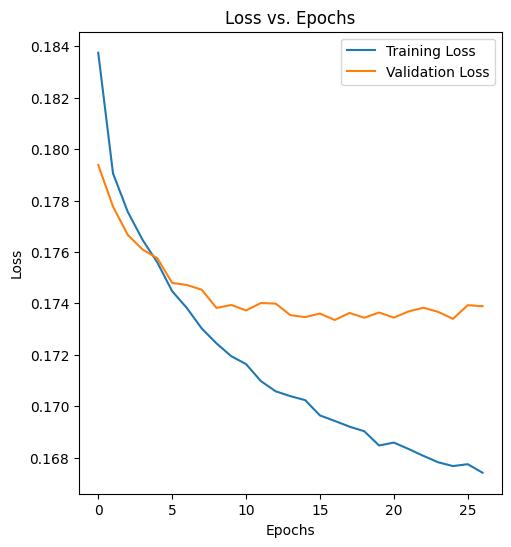

In [15]:
# Plot training history
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.legend()
plt.title('Loss vs. Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')

plt.show()

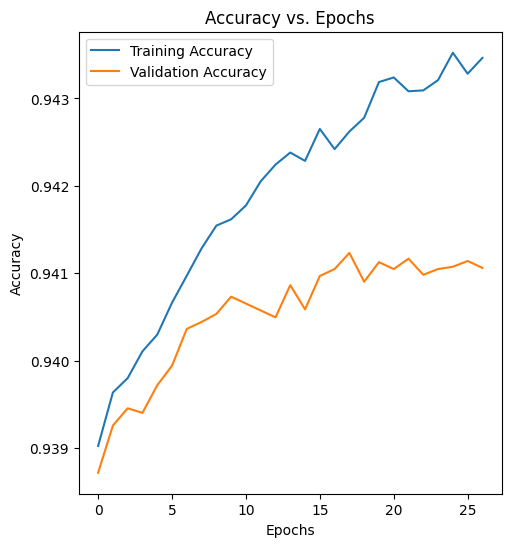

In [16]:
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.legend()
plt.title('Accuracy vs. Epochs')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')

plt.show()

OLD MODEL

In [ ]:
# Define feature columns for numerical variables
num_feature_columns = [feature_column.numeric_column(col) for col in num_var]

# Define feature columns for categorical variables
cat_feature_columns = [feature_column.categorical_column_with_vocabulary_list(col, vocabulary_list=df[col].unique()) for col in cat_var]

# Use one-hot encoding for categorical variables
cat_feature_columns = [feature_column.indicator_column(col) for col in cat_feature_columns]

# Define feature columns for binary variables
bin_feature_columns = [feature_column.categorical_column_with_vocabulary_list(col, vocabulary_list=df[col].unique()) for col in bin_var]

# Use one-hot encoding for binary variables
bin_feature_columns = [feature_column.indicator_column(col) for col in bin_feature_columns]

# Combine all feature columns
feature_columns = num_feature_columns + cat_feature_columns + bin_feature_columns

Instructions for updating:
Use Keras preprocessing layers instead, either directly or via the `tf.keras.utils.FeatureSpace` utility. Each of `tf.feature_column.*` has a functional equivalent in `tf.keras.layers` for feature preprocessing when training a Keras model.
Instructions for updating:
Use Keras preprocessing layers instead, either directly or via the `tf.keras.utils.FeatureSpace` utility. Each of `tf.feature_column.*` has a functional equivalent in `tf.keras.layers` for feature preprocessing when training a Keras model.
Instructions for updating:
Use Keras preprocessing layers instead, either directly or via the `tf.keras.utils.FeatureSpace` utility. Each of `tf.feature_column.*` has a functional equivalent in `tf.keras.layers` for feature preprocessing when training a Keras model.


In [ ]:
def create_dataset(dataframe, batch_size=32):
  dataframe = dataframe.copy()
  labels = dataframe.pop('HeartDisease')
  return tf.data.Dataset.from_tensor_slices((dict(dataframe), labels)) \
          .shuffle(buffer_size=len(dataframe)) \
          .batch(batch_size)

In [ ]:
train, test = train_test_split(df, test_size=0.2, random_state=42)

In [ ]:
train_ds = create_dataset(train)
test_ds = create_dataset(test)

In [ ]:
y_test = test_ds['HeartDisease']

TypeError: ignored

In [ ]:
model = tf.keras.models.Sequential([
  tf.keras.layers.DenseFeatures(feature_columns=feature_columns),
  tf.keras.layers.Dense(units=128, activation='relu'),
  tf.keras.layers.Dropout(rate=0.2),
  tf.keras.layers.Dense(units=128, activation='relu'),
  tf.keras.layers.Dense(units=1, activation='sigmoid')
])

In [ ]:
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])

history = model.fit(train_ds, validation_data=test_ds, epochs=100, use_multiprocessing=True)

Epoch 1/100
9496/9496 [==============================] - 56s 5ms/step - loss: 0.1892 - accuracy: 0.9389 - val_loss: 0.1831 - val_accuracy: 0.9382
Epoch 2/100
9496/9496 [==============================] - 58s 6ms/step - loss: 0.1824 - accuracy: 0.9391 - val_loss: 0.1805 - val_accuracy: 0.9385
Epoch 3/100
9496/9496 [==============================] - 57s 6ms/step - loss: 0.1809 - accuracy: 0.9393 - val_loss: 0.1801 - val_accuracy: 0.9389
Epoch 4/100
9496/9496 [==============================] - 63s 6ms/step - loss: 0.1799 - accuracy: 0.9397 - val_loss: 0.1800 - val_accuracy: 0.9385
Epoch 5/100
9496/9496 [==============================] - 57s 6ms/step - loss: 0.1790 - accuracy: 0.9400 - val_loss: 0.1796 - val_accuracy: 0.9389
Epoch 6/100
9496/9496 [==============================] - 54s 5ms/step - loss: 0.1785 - accuracy: 0.9400 - val_loss: 0.1795 - val_accuracy: 0.9400
Epoch 7/100
9496/9496 [==============================] - 58s 6ms/step - loss: 0.1780 - accuracy: 0.9402 - val_loss: 0.1780 -

In [ ]:
model.evaluate(test_ds)

2374/2374 [==============================] - 11s 4ms/step - loss: 0.1793 - accuracy: 0.9412


[0.17929333448410034, 0.9411803483963013]

In [ ]:
print(model.summary())

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_features (DenseFeatu  multiple                  0         
 res)                                                            
                                                                 
 dense (Dense)               multiple                  7040      
                                                                 
 dropout (Dropout)           multiple                  0         
                                                                 
 dense_1 (Dense)             multiple                  16512     
                                                                 
 dense_2 (Dense)             multiple                  129       
                                                                 
Total params: 23681 (92.50 KB)
Trainable params: 23681 (92.50 KB)
Non-trainable params: 0 (0.00 Byte)
____________________

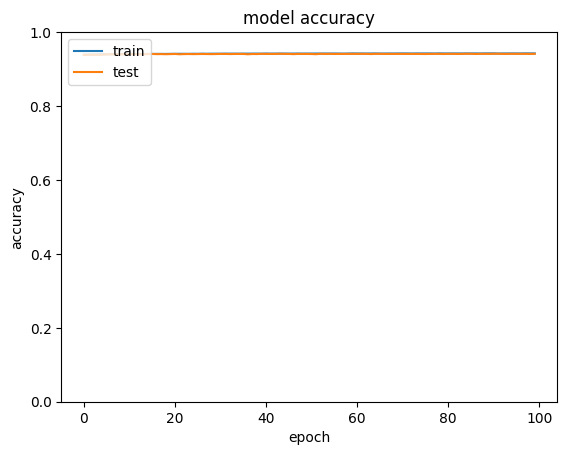

In [ ]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.ylim((0, 1))
plt.legend(['train', 'test'], loc='upper left');

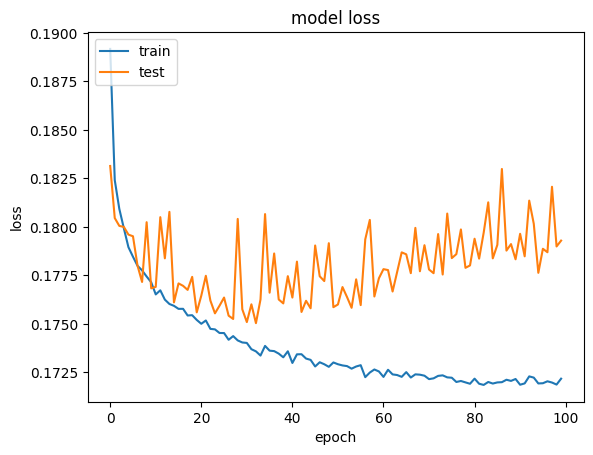

In [ ]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [ ]:
predictions = model.predict(test_ds)

2374/2374 [==============================] - 14s 5ms/step


In [ ]:
bin_predictions = tf.round(predictions).numpy().flatten()

In [ ]:
print(classification_report(y_test.values, bin_predictions))

AttributeError: ignored